In [3]:
"""
use it like 
python calibrate_camera.py --image_dir /home/fari/Pictures/calibrationcheckerboard/calibration --image_format jpg --square_size 2.5 --width 10 --height 7 --save_file ./calibration.yml --ref_plan /home/fari/Pictures/calibrationcheckerboard/ref_plan.jpg
"""
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def plot_image(img):
    fig, ax = plt.subplots(1)
    ax.imshow(img) 
    plt.axis('off')
    plt.show()


def add_points_on_image(img, points, color=(0, 255, 0), size=10, thickness=-1):
    """
    Plots a set of points on an image.
    
    Parameters:
        img (ndarray): The image on which to plot the points.
        points (list or ndarray): A list or array of (x, y) points.
        color (tuple): The color of the points in (B, G, R) format. Default is green.
        size (int): The radius of the points. Default is 5.
        thickness (int): The thickness of the points. If -1, the point will be filled. Default is -1.
        
    Returns:
        ndarray: The image with the points plotted.
    """
    
    for point in points:
        cv2.circle(img, (int(point[0]), int(point[1])), size, color, thickness)
    
    return img

def calibrate(dirpath, image_format, width, height):
    """
    Apply camera calibration operation for images in the given directory path.
    
    Parameters:
    - dirpath (str): The path to the directory containing the images.
    - image_format (str): The format of the images (e.g., 'png' or 'jpg').
    - square_size (float): Size of a square on the chessboard in real-world units (e.g., centimeters).
    - ref_plan_path (str): Path to the reference plan image.
    - width (int): Number of inner corners of the chessboard along its width.
    - height (int): Number of inner corners of the chessboard along its height.
    
    Returns:
    - ret (float): Root mean square (RMS) re-projection error.
    - mtx (numpy.ndarray): Camera matrix (intrinsic parameters).
    - dist (numpy.ndarray): Distortion coefficients.
    - rvecs (list of numpy.ndarray): Rotation vectors for each image used in calibration.
    - tvecs (list of numpy.ndarray): Translation vectors for each image used in calibration.
    """
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)
    objp = objp 

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    if dirpath[-1:] == '/':
        dirpath = dirpath[:-1]

    images = glob.glob(dirpath+'/' + '*.' + image_format)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs


def find_homography(ref_plan, width, height, square_size):
    """
    Find the homography matrix for a given reference checkerboard image.
    
    Parameters:
    - ref_plan (str or numpy.ndarray): Path to the reference checkerboard image or the image itself.
    - width (int): Number of inner corners of the checkerboard along its width.
    - height (int): Number of inner corners of the checkerboard along its height.
    
    Returns:
    - homography (numpy.ndarray): Homography matrix.
    - status (numpy.ndarray): Status of matched points (1 = valid point, 0 = invalid point).
    """
    
    # If the input is a string (path), read the image
    if isinstance(ref_plan, str):
        ref_plan = cv2.imread(ref_plan)
    
    gray = cv2.cvtColor(ref_plan, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (width, height), None)
    
    if not ret:
        raise ValueError("Checkerboard not found in the provided image.")
    
    # Define the points for the perfect grid in standard coordinates
    objp = np.zeros((height*width, 2), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)*square_size
    
    # Compute the homography matrix
    homography, status = cv2.findHomography(corners, objp)
    
    return homography, status


def save_coefficients(mtx, dist,path):
    """ Save the camera matrix, distortion coefficients and perspective matrix to given path/file. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("K", mtx)
    cv_file.write("D", dist)
    cv_file.release()


def undistort_image(img_path, mtx, dist):
    """
    Load the coefficients, undistort and warp the input image.
    
    Parameters:
    - img_path: Path to the image to be undistorted and warped.
    - calibration_file: Path to the YML file with calibration matrices.
    
    Returns:
    - undistorted_img: Undistorted image.
    """
    img = cv2.imread(img_path)
    undistorted_img = cv2.undistort(img, mtx, dist)
    return undistorted_img

def image_coordinates_to_world_coordinates(img_point, H):
    """
    Transform a point from image coordinates to world coordinates using a given homography matrix.
    
    Parameters:
    - img_point (list or tuple): Image point in the format [x, y].
    - H (numpy.ndarray): Homography matrix.
    
    Returns:
    - world_point (list): Transformed point in world coordinates in the format [X, Y].
    """
    # Convert point to homogeneous coordinates
    img_point_homogeneous = np.array([img_point[0], img_point[1], 1])
    
    # Use the homography matrix to get world coordinates in homogeneous form
    world_point_homogeneous = np.dot(H, img_point_homogeneous)
    
    # Convert back from homogeneous coordinates to 2D
    world_point = world_point_homogeneous[:2] / world_point_homogeneous[2]
    
    return world_point.tolist()


def transform_bbox_to_world(bbox, H):
    """
    Transforms an image bounding box to a 2D world coordinate bounding box.
    
    Parameters:
    - bbox: A tuple (x, y, w, h) representing the image bounding box.
    - H: The homography matrix.
    
    Returns:
    - A tuple (X_min, Y_min, X_max, Y_max) representing the world bounding box.
    """
    
    x, y, w, h = bbox
    corners_image = np.array([
        [[x, y]],
        [[x + w, y]],
        [[x, y + h]],
        [[x + w, y + h]]
    ], dtype=np.float32)
    
    corners_world = cv2.perspectiveTransform(corners_image, H)
    
    X_coords = corners_world[:, 0, 0]
    Y_coords = corners_world[:, 0, 1]
    
    X_min, X_max = np.min(X_coords), np.max(X_coords)
    Y_min, Y_max = np.min(Y_coords), np.max(Y_coords)
    
    return (X_min, Y_min, X_max, Y_max)


image_dir = "/home/fari/Pictures/calibrationcheckerboard/calibration"
square_size= 25
width=10
height=7
image_format="jpg"
save_file="./calibration.yml" 
ref_plan="/home/fari/Pictures/calibrationcheckerboard/ref_plan.jpg"

ret, mtx, dist, rvecs, tvecs= calibrate(image_dir, image_format, width, height)
ref_plan = undistort_image(ref_plan, mtx, dist)
H, _ = find_homography(ref_plan, width, height, square_size)
    
print("Calibration is finished. RMS: ", ret)



Calibration is finished. RMS:  0.6054663921181621


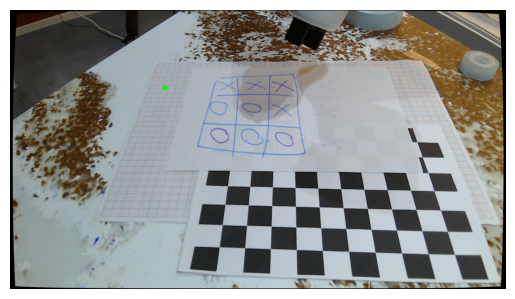

[1.9104263630975757, 4.822931674055237]

In [26]:
img = undistort_image("test.jpg", mtx, dist)
points = [[600, 300]]
plot_image(add_points_on_image(img, points))

image_coordinates_to_world_coordinates(points[0], H)




(11.286463, 3.466524, 12.099736, 3.556223)